In [36]:
#autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import pandas as pd
from model import *
from viz import *
from dataset import *
from data import *

In [38]:
df = load_tload('data/buildings/datasets/2024/GATES_zone-tloads.csv')
weather = load_weather('data/buildings/datasets/2024/weather.csv')

In [39]:
weather = pd.DataFrame(index=weather.index, columns=['nothing'])
weather.fillna(0, inplace=True)
weather

/var/folders/n7/7ln3k6zx5hj40n1dc441clm40000gn/T/ipykernel_33506/3038070797.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weather.fillna(0, inplace=True)


nothing
Date                        
2024-04-29 00:00:00        0
2024-04-29 01:00:00        0
2024-04-29 02:00:00        0
2024-04-29 03:00:00        0
2024-04-29 04:00:00        0
...                      ...
2024-09-19 19:00:00        0
2024-09-19 20:00:00        0
2024-09-19 21:00:00        0
2024-09-19 22:00:00        0
2024-09-19 23:00:00        0

[3454 rows x 1 columns]

In [40]:
df.dropna(inplace=True)

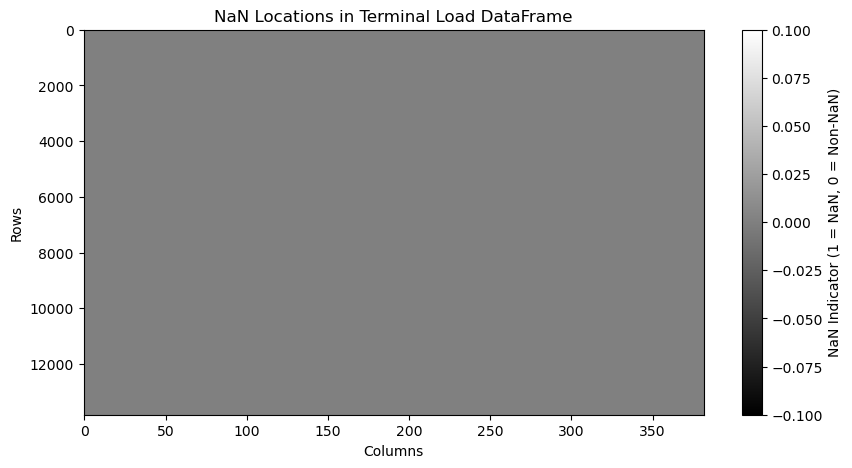

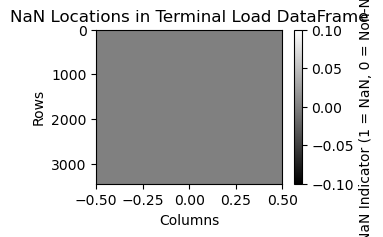

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [42]:
nan_viz(df, wide = True)
nan_viz(weather)

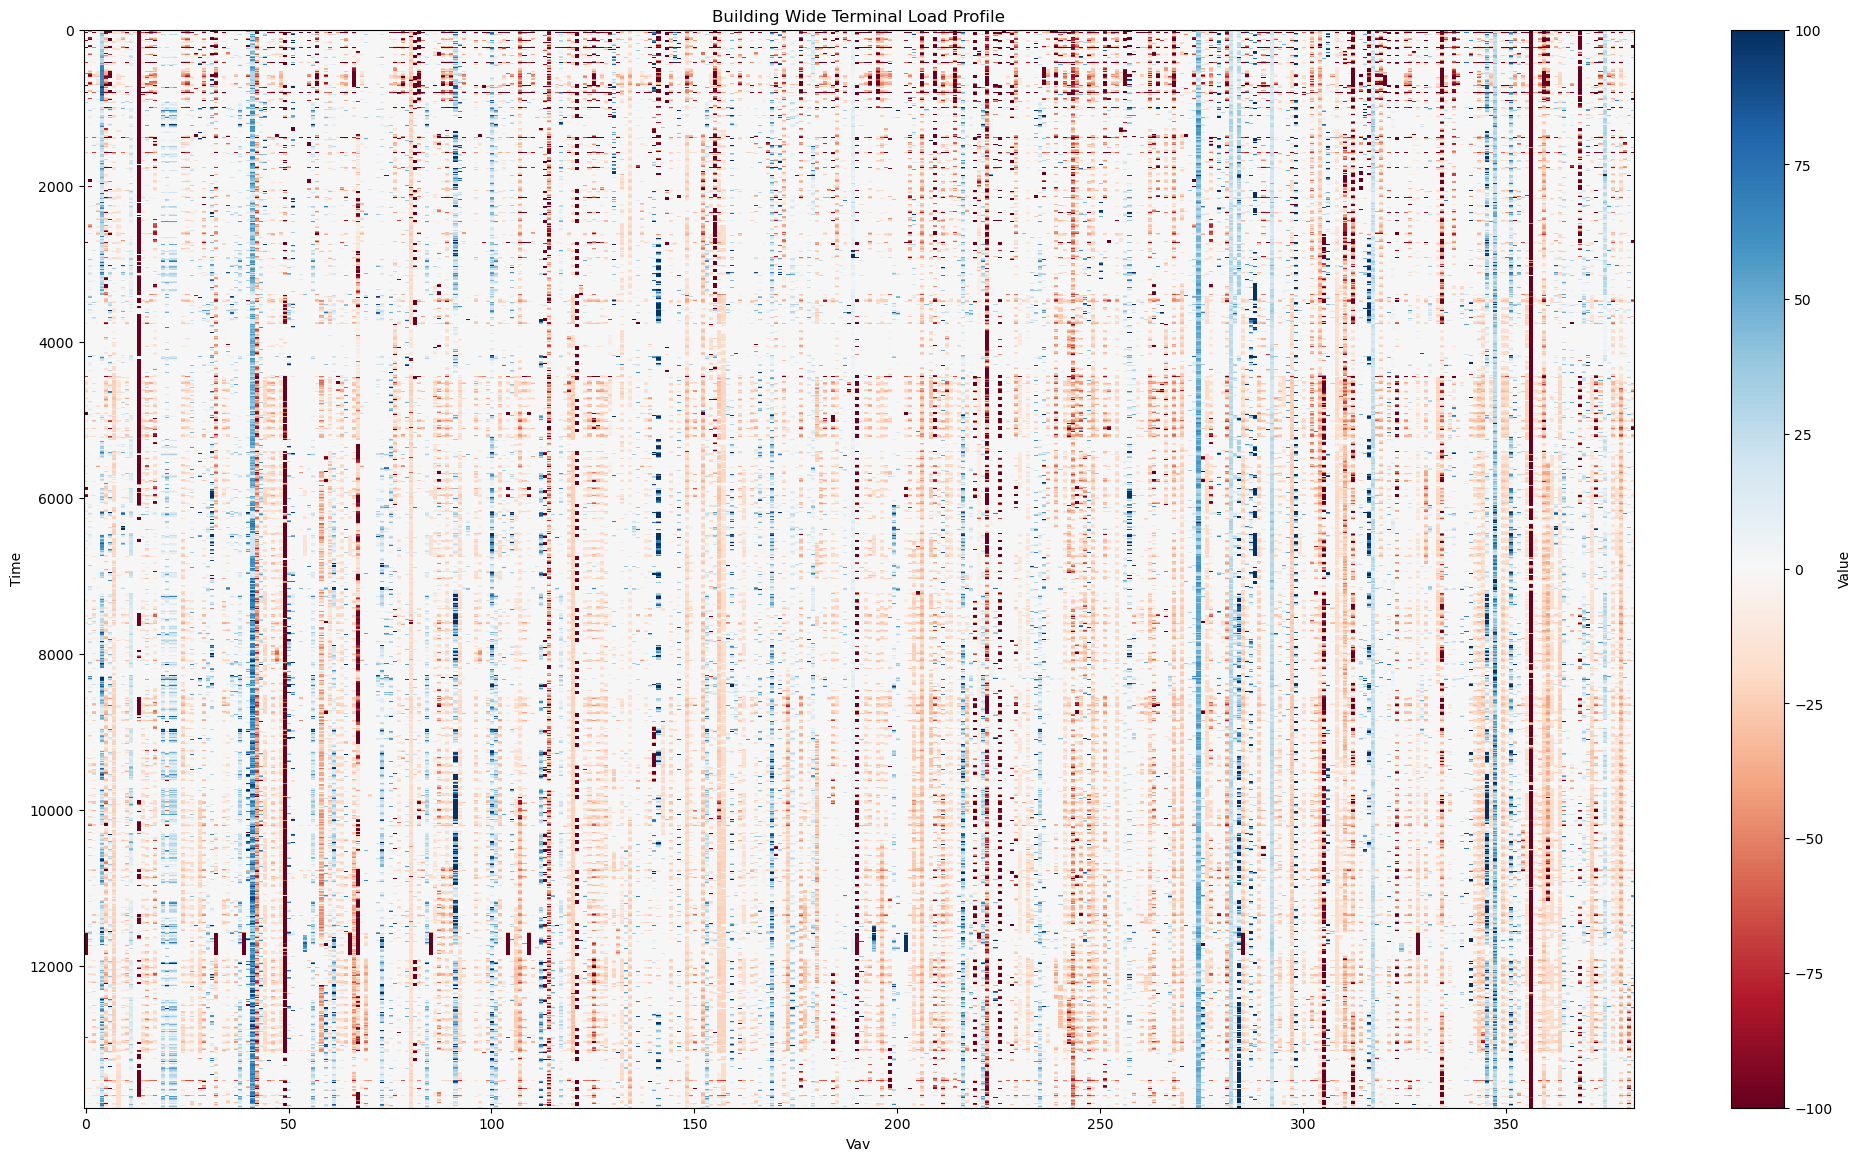

In [43]:
tload_viz(df)

We have time series for a given building, corresponding do each zone terminal load, a measure of how needy a zone i in term of cooling or reheat. 

We'll denote this:

$$T_{load}^{(z,t)}$$

With $t$ indexing the time and $z$ denoting the zone of the building. We have  382  zone in this building, which makes a vector of 
$$T_{load, building}^{t} \in \mathbb R ^{(382,1)}$$

We also have a input feature timeseries, which is common for all the building as well. This includes features such as Outside Air temperautre or solar irradiation. 

$$W^{t}$$

In the code the weather dataframe is formatted like so:
| Date                | temperature | RH  | Tdew | wind | sun_rad | daily_rain |
|---------------------|-------------|-----|------|------|---------|------------|
| 2023-05-01 00:00:00 | 52.6        | 75.0| 44.8 | 9.2  | 0.0     | 0.00       |
| 2023-05-01 01:00:00 | 52.4        | 75.0| 44.7 | 7.4  | 0.0     | 0.00       |
| 2023-05-01 02:00:00 | 52.2        | 75.0| 44.4 | 9.0  | 0.0     | 0.00       |

And the 

| Date                | VAV2-33 | VAV2-17   | VAV3-18 | VAV4-22    | VAV2-20 | VAV1-18 | VAV2-03   | VAV3-06 | VAV2-31 | VAV2-29 | ... | VAV2-11 | VAV2-32 | VAV4-25    | VAV4-08 | VAV1-02   | VAV0-00-4  | VAV0-04 | VAV1-12 | VAV2-18 | VAV3-15 |
|---------------------|---------|-----------|---------|------------|---------|---------|-----------|---------|---------|---------|-----|---------|---------|------------|---------|-----------|------------|---------|---------|---------|---------|
| 2023-05-01 00:00:00 | 0.0     | 0.000000  | 0.0     | -10.687083 | 0.0     | 0.0     | -5.494500 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.662916 | 0.0     | -0.435333 | -8.518917  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 01:00:00 | 0.0     | -0.355917 | 0.0     | -10.881667 | 0.0     | 0.0     | -7.798417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.492833 | 0.0     | -7.894917 | -7.576250  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 02:00:00 | 0.0     | -0.559250 | 0.0     | -10.827083 | 0.0     | 0.0     | -6.123417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.670916 | 0.0     | -6.497750 | -8.176333  | 0.0     | 0.0     | 0.0     | -1.364750|

I want to train a LSTM architecture that will for an input of the past 2 weeks of data of terminal load vector, will try to predict the next week. I also have the exact weather for the two past weeks and the predicting wek (that could be a forcecast in real life use), to help the prediction of model, as those should be correlated in some ways. 

Give me a way to start formatting my code to have such a model, train it and test it. I want to have september has my validation set. 


# Quick look at the data

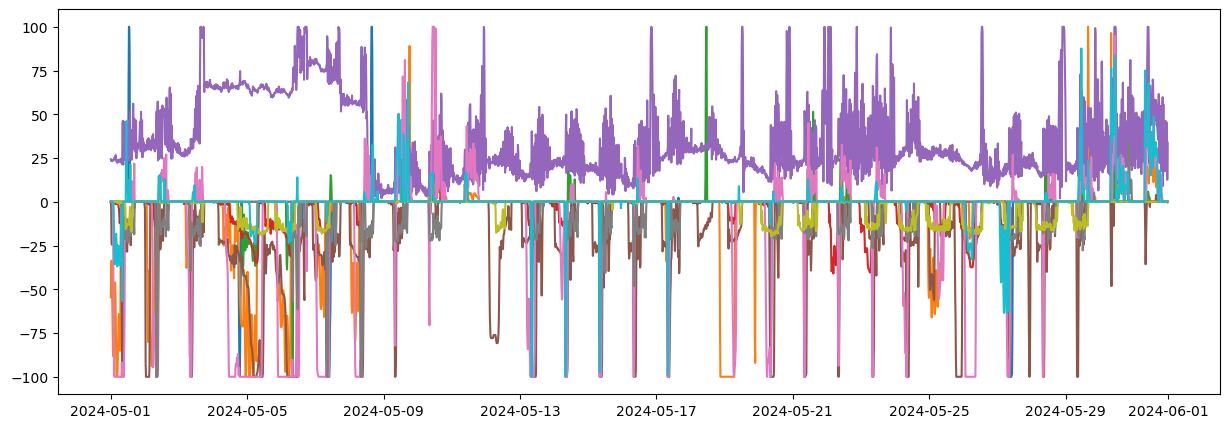

In [44]:
plt.figure(figsize=(15,5))
for col in df.columns[:10]:
    plt.plot(df.loc[df.index.month == 5,col], label=col)

# Hyperparameters choice

In [46]:
n_epochs = 400 

# Base model

In [47]:
# Make sure both dataframes have datetime indices
df.index = pd.to_datetime(df.index)
weather.index = pd.to_datetime(weather.index)

# Train the model
model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader = get_trained_model(df, weather, n_epochs=n_epochs,p_dropout=0.2)

Checking data availability...
Terminal loads date range: 2024-04-29 00:00:00 to 2024-09-19 23:45:00
Weather data date range: 2024-04-29 00:00:00 to 2024-09-19 23:00:00

Using split date: 2024-08-21 00:00:00

Checking data sizes:
Training set hours: 10942
Validation set hours: 2880
Minimum required hours: 192

Creating datasets...
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 383)
Future weather: (24, 1)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 383)
Future weather: (24, 1)
Target loads: (24, 382)

Creating dataloaders...

Initializing model...

Starting training...
Training on device: mps
Number of training batches: 4
Number of validation batches: 1
Epoch [5/400], Train Loss: 1.2166, Val Loss: 1.0048
Epoch [10/400], Train Loss: 1.1787, Val Loss: 1.0024
Epoch [15/400], Train Loss: 1.1316, Val Loss: 0.9972
Epoch [20/400], Train Loss: 1.0966, Val Loss: 0.9919
Epoch [25/400], Tr

# Saving the models

In [48]:
import torch
import pickle

# Example usage
model_path = 'model/model1_without_weather.pth'
data_path = 'model/data1_without_weather.pkl'
save_all(model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader, model_path, data_path)

# Loading the model

In [24]:

model_path = 'model/model_without_weather.pth'
data_path = 'model/data_without_weather.pkl'
model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader = load_all(model_path, data_path)

/Users/alexisbonnafont/Documents/CS230/Deep_Building/model.py:281: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


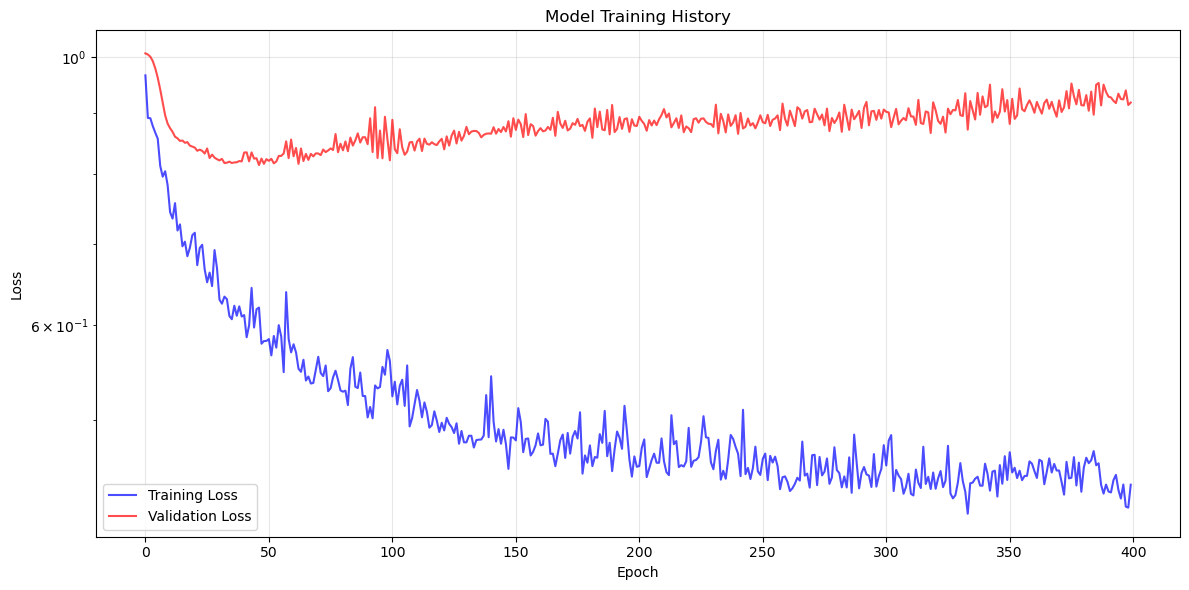

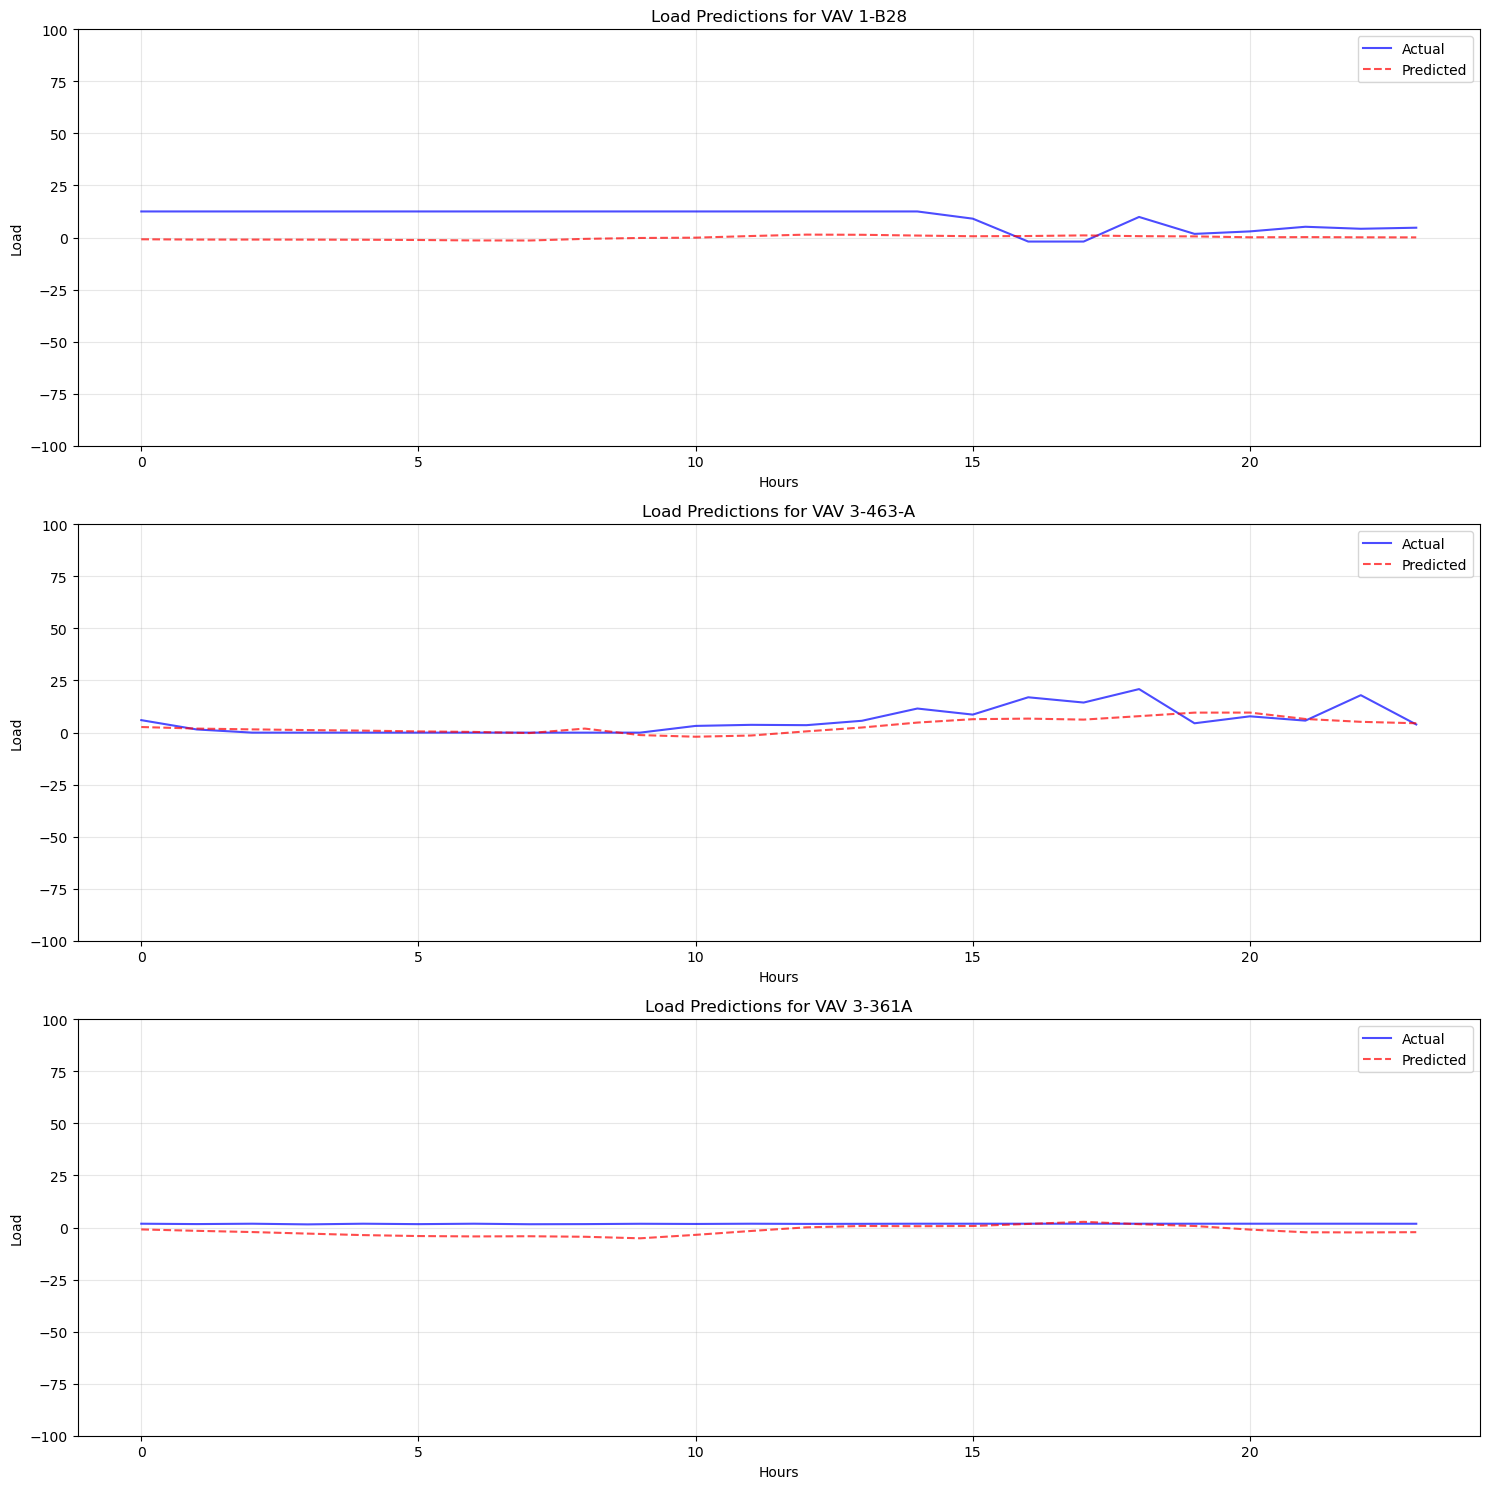

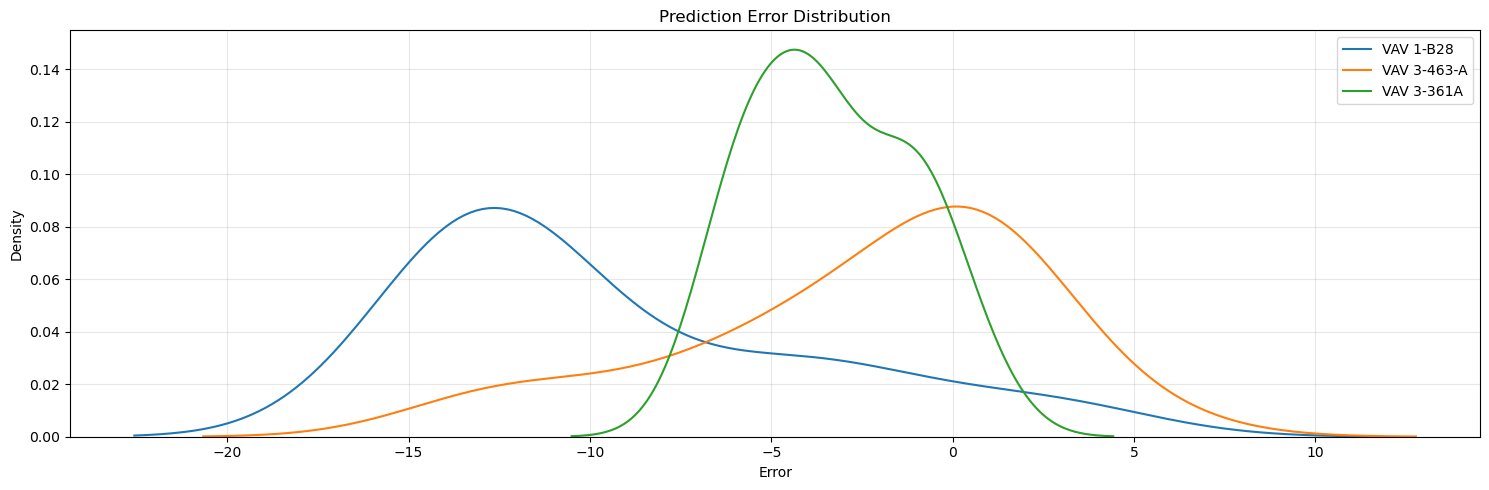


Prediction Metrics:
--------------------------------------------------

VAV 1-B28:
MAPE: 103.22%
RMSE: 10.70

VAV 3-463-A:
MAPE: 750.13%
RMSE: 5.32

VAV 3-361A:
MAPE: 195.55%
RMSE: 3.98


In [55]:
# Correct way to call visualize_results
visualize_results(
    model=model,
    dataset=val_dataset,  # The dataset object
    load_scaler=train_dataset.load_scaler,  # The actual scaler object
    train_losses=train_losses,
    val_losses=val_losses,
    zones_names=df.columns,
    sample_idx=0,
    n_samples=3,
)

# Error Analysis

In [13]:
all_errors, all_predictions, all_targets = calculate_errors(model, val_dataset, val_dataset.load_scaler)

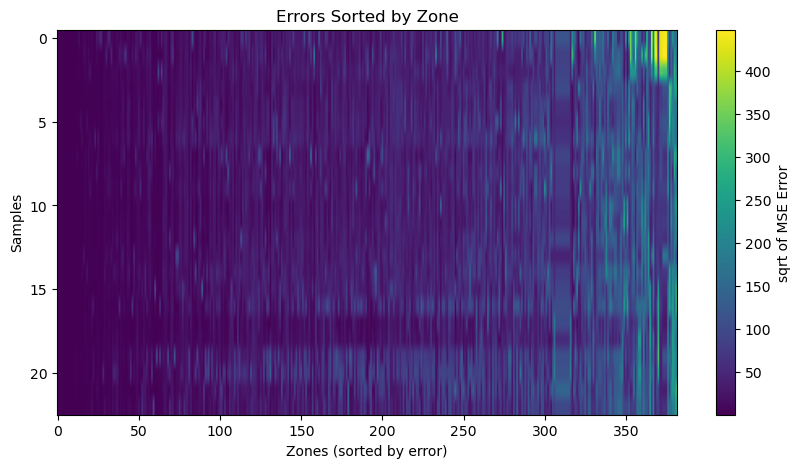

[11 20  9]


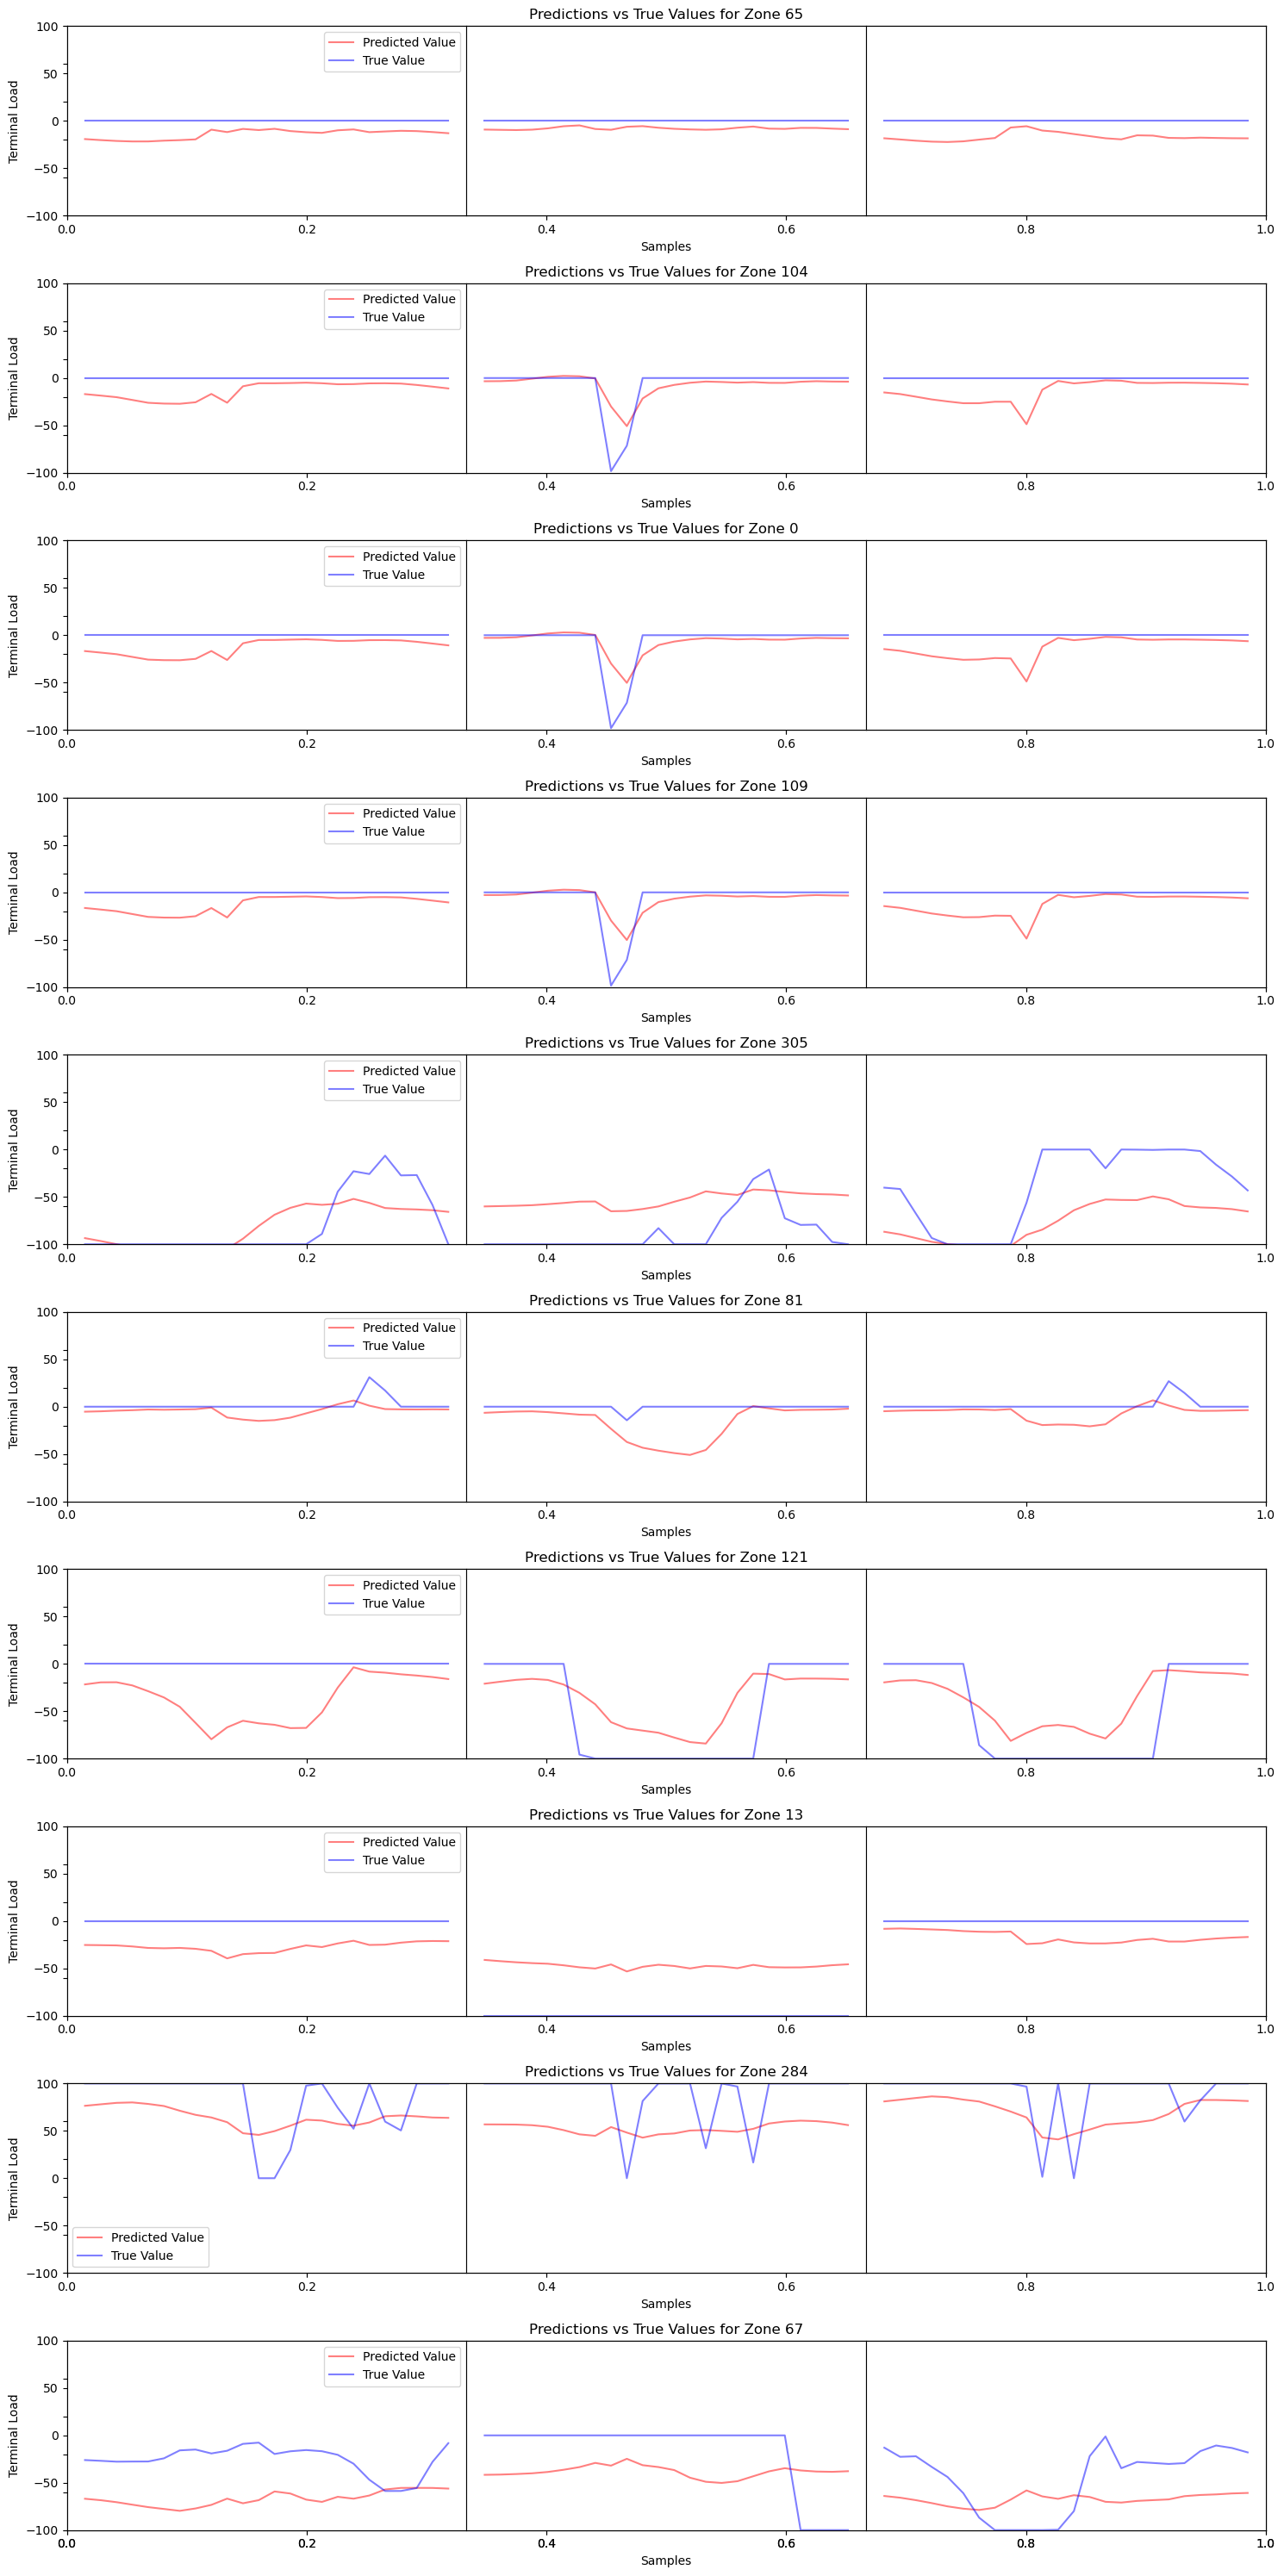

[12 14  1]


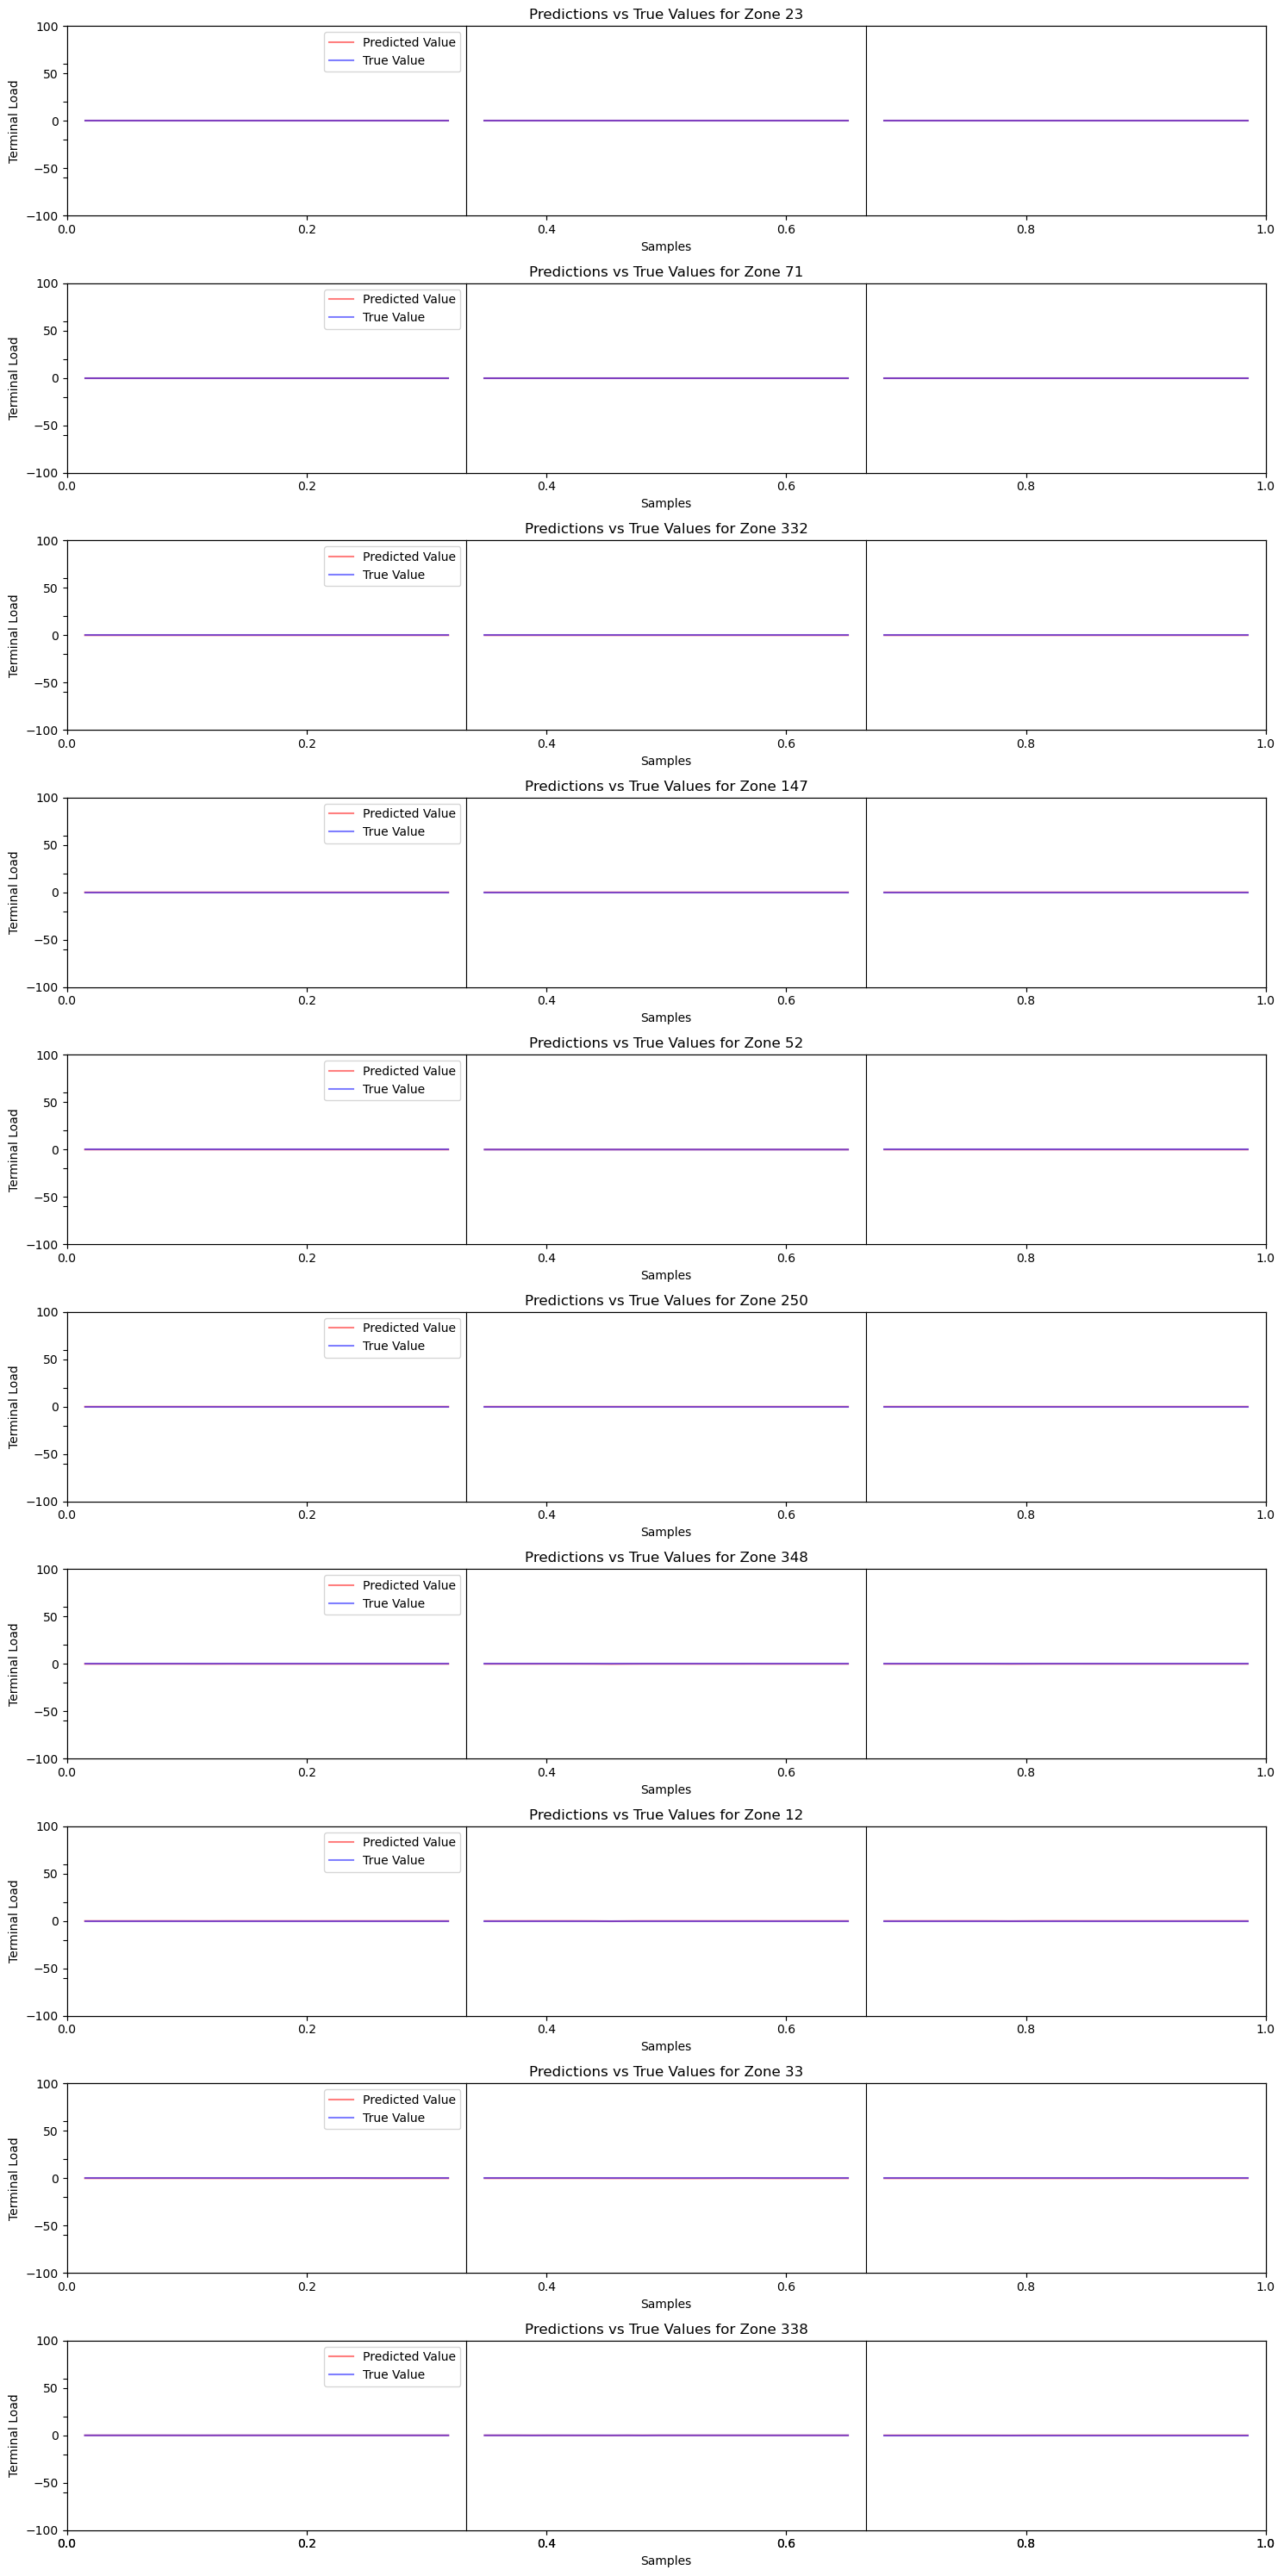

In [14]:
from viz import plot_dataset_error, plot_bad_samples_predictions

plot_dataset_error(all_errors)

plot_bad_samples_predictions(all_errors, all_predictions, all_targets, N_samples=3, N_zones=10)
plot_bad_samples_predictions(all_errors, all_predictions, all_targets, good_zones=True,N_samples=3, N_zones=10)

<Axes: xlabel='Date'>

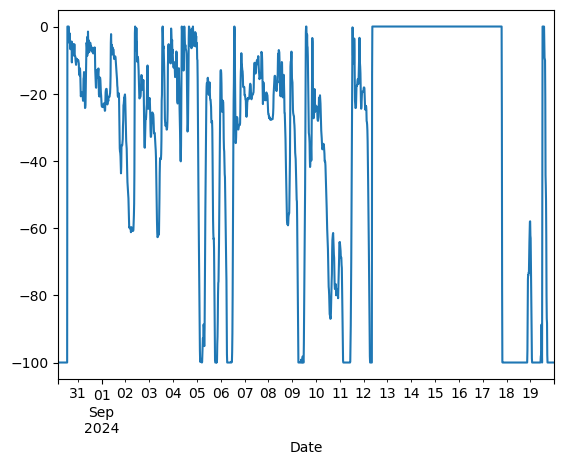

In [24]:
df.iloc[-2000:,67].plot()

# Building wide prediction

In [16]:
all_errors, all_predictions, all_targets = calculate_errors(model, train_dataset, train_dataset.load_scaler)

In [17]:
concatenated_predictions = np.concatenate([all_predictions[sample] for sample in range(all_predictions.shape[0])], axis=0)
concatenated_predictions.shape  

(2544, 382)

In [18]:
predictions_df = pd.DataFrame(concatenated_predictions, columns=df.columns)
predictions_df = predictions_df.map(lambda x: max(-100,x))
predictions_df.index = df.iloc[-concatenated_predictions.shape[0]:].index

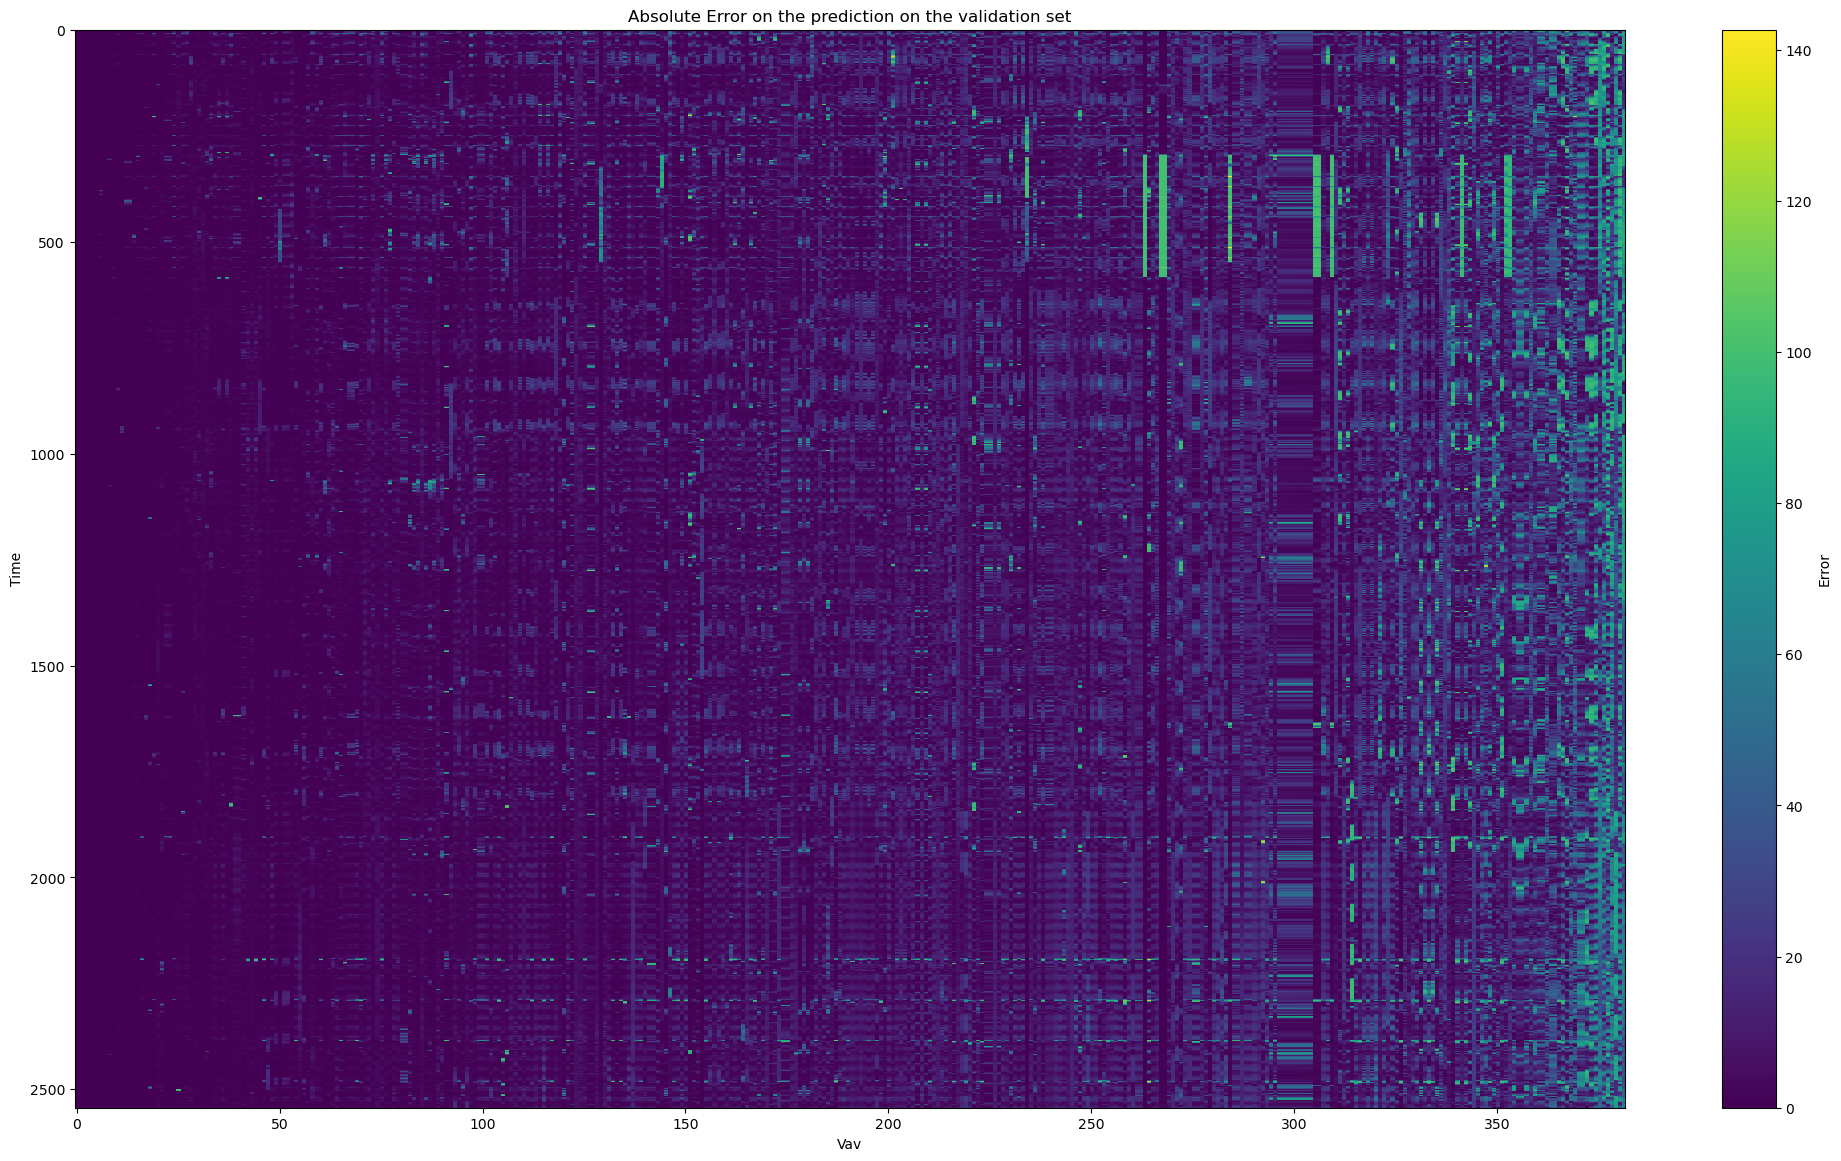

In [19]:
from data import error_viz
error_df = predictions_df - df.iloc[-concatenated_predictions.shape[0]:]
# Sort the columns in ascending order of error
error_df = error_df[error_df.abs().mean().sort_values().index]
error_viz(error_df)

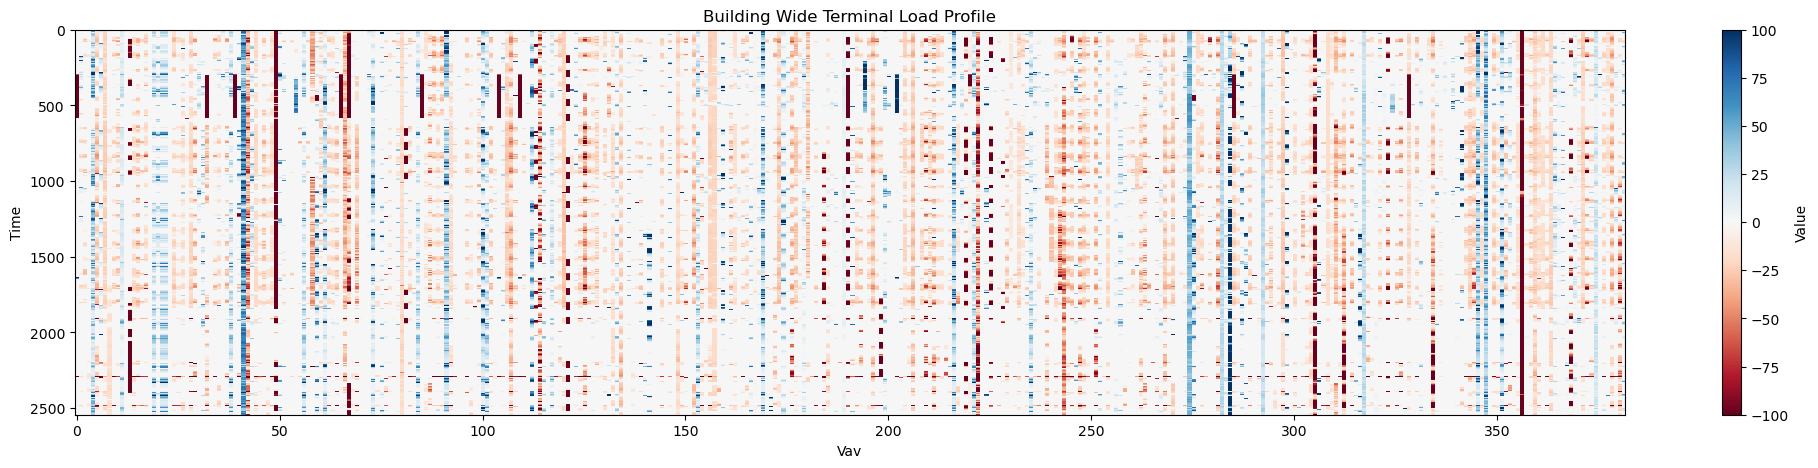

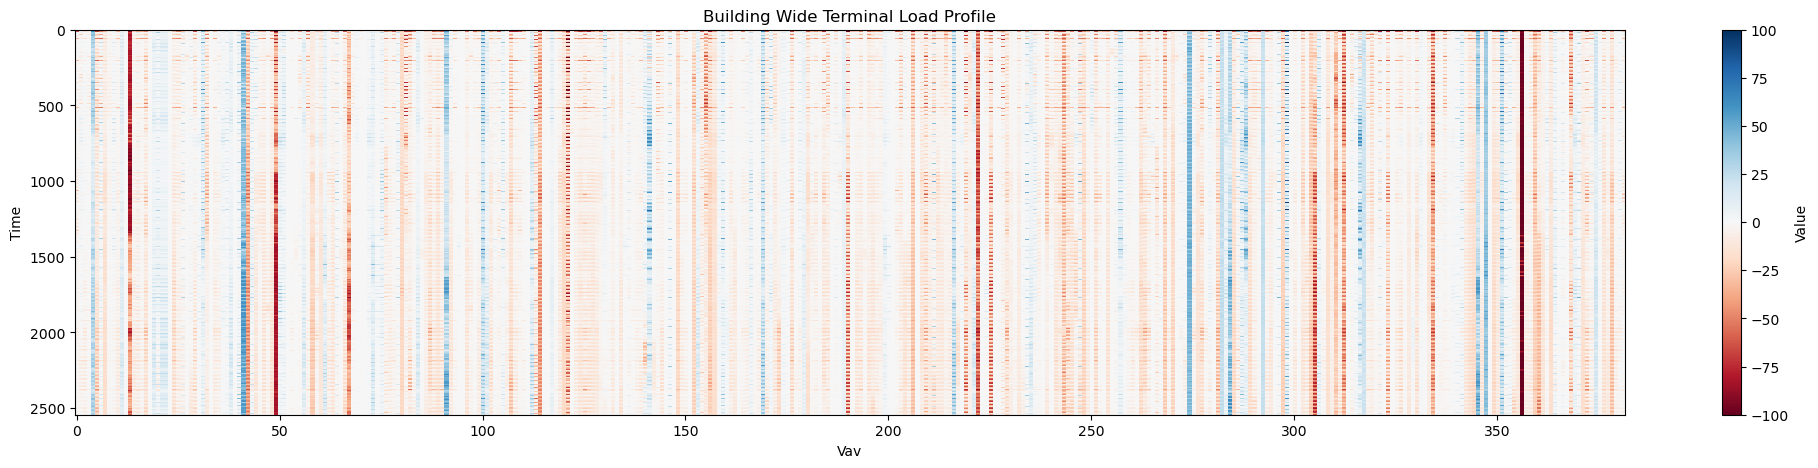

In [20]:
tload_viz(df.iloc[-concatenated_predictions.shape[0]:], small=True)
tload_viz(predictions_df, small=True)

# Which zones are more variable?

In [23]:
variable_vav = df.map(lambda x: max(x,0)).std().sort_values().tail(10).index

In [24]:
variables_idx

NameError: name 'variables_idx' is not defined

In [ ]:
variables_idx = df.columns.get_indexer(variable_vav)

<Axes: xlabel='Date'>

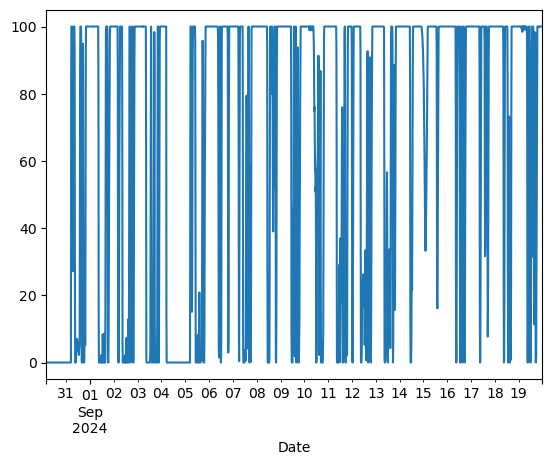

In [ ]:
df.iloc[-2000:,284].plot()

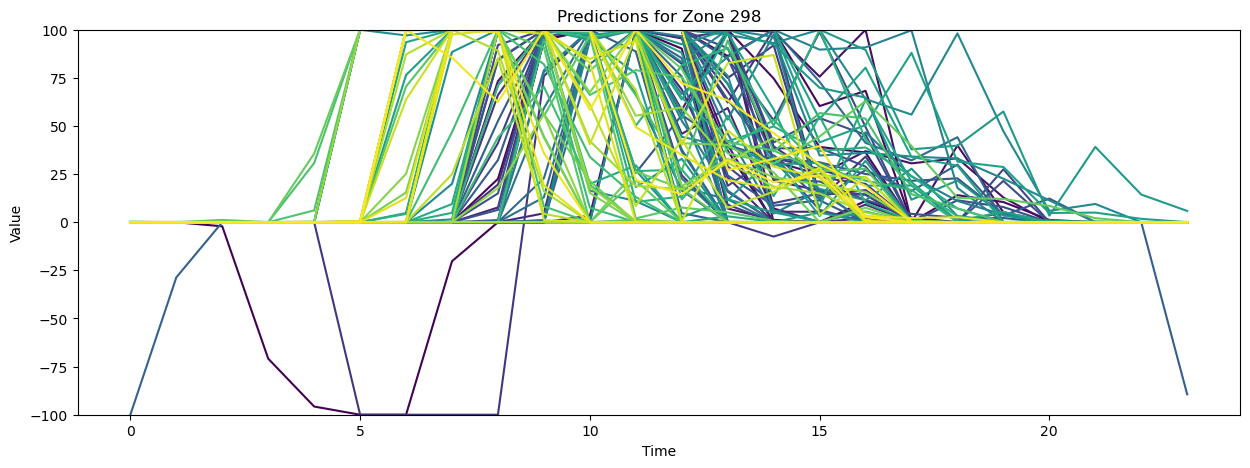

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_targets is a 3D numpy array with shape (num_samples, num_timesteps, num_zones)
# Assuming you want to plot for zone 225

zone = 298
num_samples = all_targets.shape[0]

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_samples))

plt.figure(figsize=(15, 5))
for sample in range(num_samples):
    plt.plot(all_targets[sample, :, zone], color=colors[sample])

plt.ylim(-100, 100)
plt.title(f'Predictions for Zone {zone}')
plt.xlabel('Time')
plt.ylabel('Value')

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_samples-1))
sm.set_array([])

plt.show()

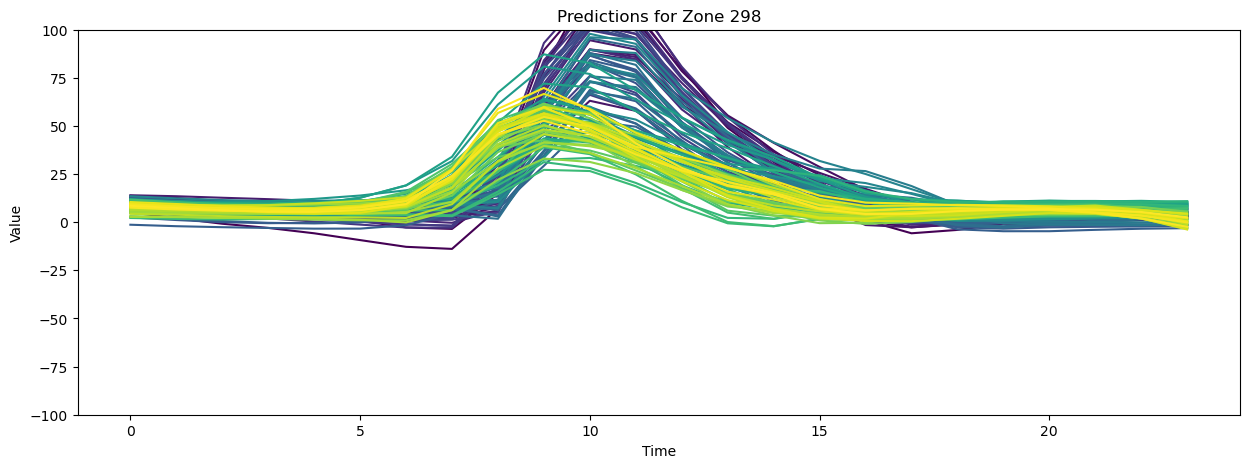

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_predictions is a 3D numpy array with shape (num_samples, num_timesteps, num_zones)
# Assuming you want to plot for zone 225

zone = 298
num_samples = all_predictions.shape[0]

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_samples))

plt.figure(figsize=(15, 5))
for sample in range(num_samples):
    plt.plot(all_predictions[sample, :, zone], color=colors[sample])

plt.ylim(-100, 100)
plt.title(f'Predictions for Zone {zone}')
plt.xlabel('Time')
plt.ylabel('Value')

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_samples-1))
sm.set_array([])

plt.show()

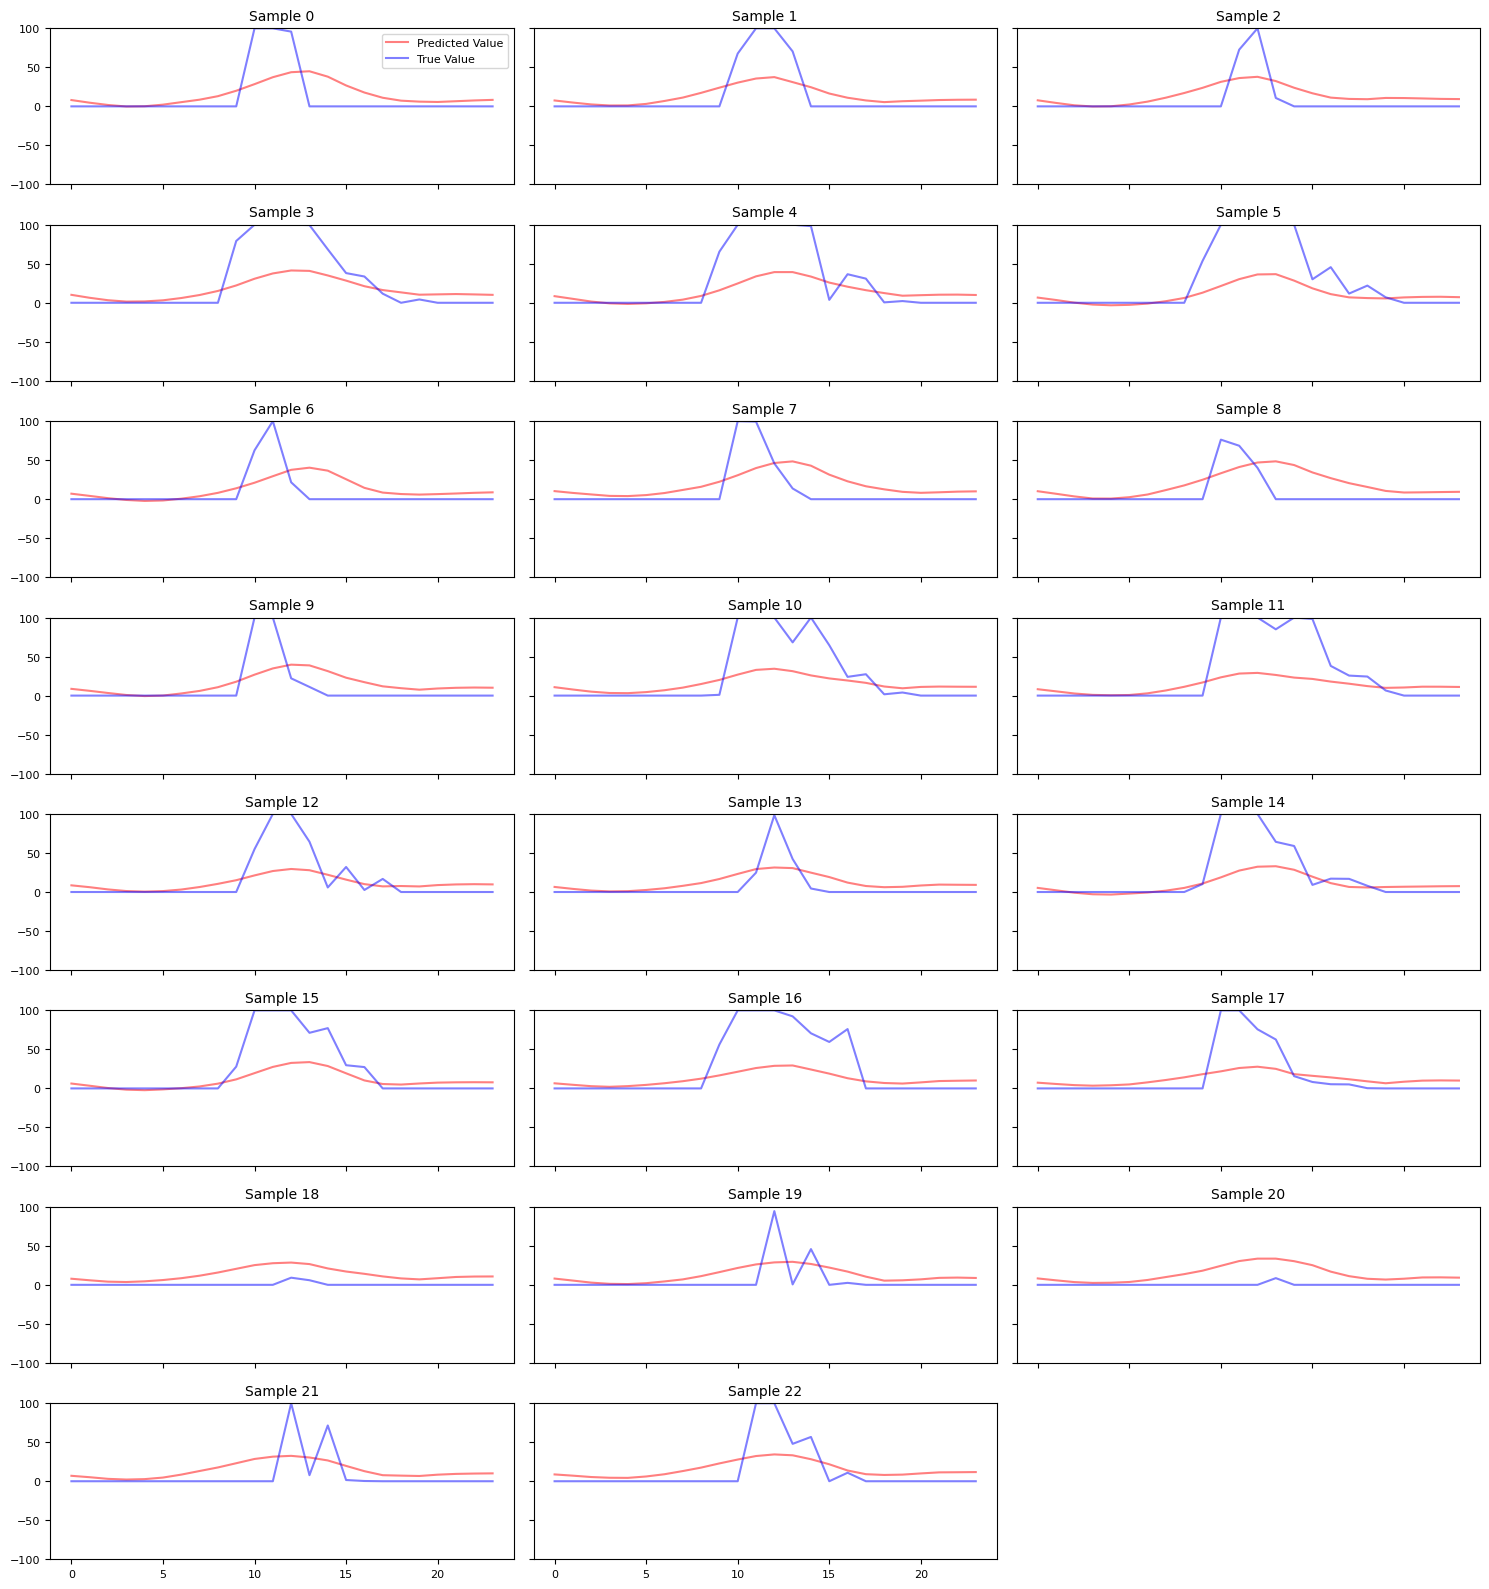

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_predictions and all_targets are 3D numpy arrays with shape (num_samples, num_timesteps, num_zones)
# Assuming you want to plot for zone 225

zone = 298
num_samples = all_predictions.shape[0]
samples_per_row = 3
num_rows = (num_samples + samples_per_row - 1) // samples_per_row  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, samples_per_row, figsize=(15, 2 * num_rows), sharex=True, sharey=True)

for sample in range(num_samples):
    row = sample // samples_per_row
    col = sample % samples_per_row
    axs[row, col].plot(all_predictions[sample, :, zone], label='Predicted Value', color='red', alpha=0.5)
    axs[row, col].plot(all_targets[sample, :, zone], label='True Value', color='blue', alpha=0.5)
    axs[row, col].set_ylim(-100, 100)
    axs[row, col].set_title(f'Sample {sample}', fontsize=10)
    axs[row, col].tick_params(axis='both', which='major', labelsize=8)
    if sample == 0:
        axs[row, col].legend(fontsize=8)

# Hide any empty subplots
for i in range(num_samples, num_rows * samples_per_row):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()